In [1]:
# Libraries
import pandas as pd
import numpy as np
import os #required to list file names in folder to load them into dataframes
import glob

# Required for Public holidays
from datetime import date
import holidays # pip install holidays [https://pypi.org/project/holidays/]

# Required to normalise the values for logistic regression
from sklearn import preprocessing

# Required for visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Required for Logistic Regression
from sklearn.linear_model import LogisticRegression


# Required for Investigations to Improve Accuracy
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


C:\Users\ellio\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# If you would like to 'Run All code' then please enter the desired dales prediction date.
# Please use the format YYYY-MM-DD
prediction_dt = '2017-04-01'

In [31]:
# Create a single dataframe that contains all SKUs, Pirce and Units from the individual source files. The DF will be 
# twice the size, given Price will be populated in the top hald and Units in the bottom half.
files = glob.glob("./data/sku_price/*.csv") + glob.glob("./data/sku_unitssold/*.csv")
combined = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep = ';')
    df['ident'] = file
    combined = combined.append(df, ignore_index = True, sort=True)

In [37]:
# A new 'Date' column will be added to the DF. This value is derived from the filename/ path of the source file.
combined['Date'] = (combined.ident.replace(to_replace =r'^.\W\w+\W\w+\W', value = '', regex = True)
                        .str.strip('.csv'))

In [38]:
# Columns renamed into something easier to work with. Note that the SKU is a string (Object) and not an integer - therefore
# will be named 'SKUstr'
combined.rename(columns={'ga:productSku': 'SKUstr', 'ga:revenuePerItem': 'UnitPrice','ga:uniquePurchases': 'Units'}, inplace=True)

In [39]:
# Working DF with each SKU only appearing once is made using Groupby
df = combined.groupby(['Date','SKUstr'])['Units','UnitPrice'].sum()
df.reset_index(inplace=True)
df.head()

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Date,SKUstr,Units,UnitPrice
0,2017-03-01,3108547,1.0,102.67
1,2017-03-01,3108850,1.0,415.78
2,2017-03-01,3109793,1.0,214.80
3,2017-03-01,3109978,1.0,156.00
4,2017-03-01,3114551,1.0,25.33


In [40]:
# A new 'SKUint' column will be added to the DF. This is done by converting the SKUstr into integers. 
# Any errors will results in a 0 (to be dealth with later)
df['SKUint'] =  pd.to_numeric(df['SKUstr'], errors='coerce').fillna(0).astype(np.int64)

# The Extended, or Total Price per transaction is calculated by multiplying the Units by the Price
df['ExtPrice'] = df['Units'] * df['UnitPrice']

In [41]:
# Adding (and checking) a flag to identify SKUs that will need to be substitued (i.e. SKUsub).
df['subSKU'] = np.where(df['SKUint']==0,1,0)
display(df[df['SKUint']!=0].head())
display(df[df['SKUint']==0].head())

,Date,SKUstr,Units,UnitPrice,SKUint,ExtPrice,subSKU
0,2017-03-01,3108547,1.0,102.67,3108547,102.67,0
1,2017-03-01,3108850,1.0,415.78,3108850,415.78,0
2,2017-03-01,3109793,1.0,214.80,3109793,214.80,0
3,2017-03-01,3109978,1.0,156.00,3109978,156.00,0
4,2017-03-01,3114551,1.0,25.33,3114551,25.33,0


,Date,SKUstr,Units,UnitPrice,SKUint,ExtPrice,subSKU
62,2017-03-01,S080501_500_30_EUR,7.0,0.98,0,6.86,1
134,2017-03-02,S080501_500_30_EUR,3.0,0.98,0,2.94,1
191,2017-03-03,S080501_500_30_EUR,4.0,0.98,0,3.92,1
280,2017-03-04,S080501_500_30_EUR,7.0,0.98,0,6.86,1
318,2017-03-05,S080501_500_30_EUR,3.0,0.98,0,2.94,1


In [42]:
# To deal with non-integer SKUs a new DF will be created and 'pseudo' SKUs will be added by taking the current
# MAX integer and adding +1
non_digit_SKU_units = df.loc[df['SKUstr'].str.contains(r"\D", na=False) , 'SKUstr'].unique()
display(non_digit_SKU_units)
for SKU in non_digit_SKU_units:
    df['SKUint'] = np.where((df['SKUstr'] == SKU), 
                           df['SKUint'].max()+1,      
                           df['SKUint'])     

array(['S080501_500_30_EUR', 'S080501_1500_30_EUR'], dtype=object)

In [43]:
# Checking that this has worked &
# Created 2 new SKUs (3169822, 3169823 respectively) based on 'S080501_500_30_EUR', 'S080501_1500_30_EUR' above.
df.loc[df['SKUstr'].str.contains(r"\D", na=False)]
df_trans = df.copy()

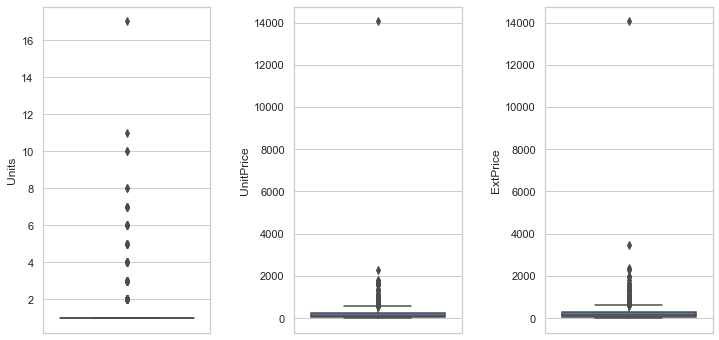

In [44]:
# As part of data cleaning, it is usually important look for outliers in the data, which has been done before.
# Note: Given the relatively small dataset AND requirement to predict a probability for EACH SKU, I did not feel that there 
# was an option but to keep all data. Happy to discuss this in person.

fig, ax = plt.subplots(1,3, figsize=(12, 6))
sns.boxplot(y=df_trans['Units'], ax=ax[0])
sns.boxplot(y=df_trans['UnitPrice'], ax=ax[1])
sns.boxplot(y=df_trans['ExtPrice'], ax=ax[2])
plt.subplots_adjust(wspace=0.5)

In [45]:
# Creating a lookup table to help identify the STRING and INTEGER versions of each SKU - most important for the non-digit SKUs
# as they will need to be replaced with the final probability  CSV output.
df_SKU_lookup = df_trans.groupby('SKUstr')['SKUint'].agg(['unique']).reset_index()
df_SKU_lookup.columns = ['SKUstr','SKUintArray']
df_SKU_lookup['SKUint'] = df_SKU_lookup.apply(lambda x: x.str[-1]).iloc[:,-1]
df_SKU_lookup.drop(['SKUintArray'], axis=1, inplace=True)

# Displaying the resulting
display(df_SKU_lookup.dtypes)
print("The shape of the SKU lookup table is (below): ")
display(df_SKU_lookup.shape)
print("The number of unique STRING versions of SKU in lookup table are: {}".format(len(df_SKU_lookup['SKUstr'].unique())))
print("The number of unique INTEGER versions of SKU in lookup table are: {}".format(len(df_SKU_lookup['SKUint'].unique())))
display(df_SKU_lookup.head())
display(df_SKU_lookup.tail())

SKUstr    object
SKUint     int64
dtype: object

The shape of the SKU lookup table is (below): 


(1270, 2)

The number of unique STRING versions of SKU in lookup table are: 1270
The number of unique INTEGER versions of SKU in lookup table are: 1245


,SKUstr,SKUint
0,312996,312996
1,323294,323294
2,337140,337140
3,340663,340663
4,356699,356699


,SKUstr,SKUint
1265,399822,399822
1266,399853,399853
1267,399980,399980
1268,S080501_1500_30_EUR,3169823
1269,S080501_500_30_EUR,3169822


In [46]:
# Creating a small DF that contains only the STRING (and equivalent INT) SKUs that have been replaced.
df_SKU_replacements = df_SKU_lookup[df_SKU_lookup['SKUstr'].str.contains("EUR", na=False)].reset_index()
df_SKU_replacements

,index,SKUstr,SKUint
0,1268,S080501_1500_30_EUR,3169823
1,1269,S080501_500_30_EUR,3169822


In [47]:
# Part 1 - Getting data required to calculate  AWP i.e. Sum of Units and Sum of Extended Revenue
# Note: - using SKUint as this is the truly unique SKU - only 1245 of them.
df_awp = df_trans.groupby(['SKUint'])['Units','ExtPrice'].agg('sum').reset_index()
df_awp.columns = ['SKU','TotalUnits','TotalRev']

# Part 2 - Calculating AWP
df_awp['AWP'] = df_awp.TotalRev  / df_awp.TotalUnits

# Part 3 - Creating a pseudo inventory master file with all relevant data that can be 
# used for feature engineering (AWP, max units, max price)
df_inv_mast = df_awp.copy()

print("df_awp info:")
display(df_awp.shape)
display(df_awp.head())

print("df_inv_mast info:")
display(df_inv_mast.shape)
display(df_inv_mast.dtypes)
display(df_inv_mast.isna().sum())
display(df_inv_mast.head())

df_awp info:


C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(1245, 4)

,SKU,TotalUnits,TotalRev,AWP
0,32166,1.0,1569.42,1569.42
1,32322,1.0,134.89,134.89
2,33146,1.0,408.00,408.00
3,33151,1.0,295.00,295.00
4,33582,1.0,23.14,23.14


df_inv_mast info:


(1245, 4)

SKU             int64
TotalUnits    float64
TotalRev      float64
AWP           float64
dtype: object

SKU           0
TotalUnits    0
TotalRev      0
AWP           0
dtype: int64

,SKU,TotalUnits,TotalRev,AWP
0,32166,1.0,1569.42,1569.42
1,32322,1.0,134.89,134.89
2,33146,1.0,408.00,408.00
3,33151,1.0,295.00,295.00
4,33582,1.0,23.14,23.14


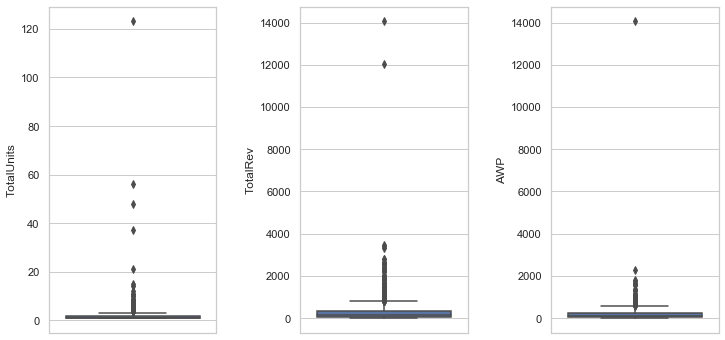

In [48]:
# As above, checking for outliers in df_inv_mast.
fig, ax = plt.subplots(1,3, figsize=(12, 6))
sns.boxplot(y=df_inv_mast['TotalUnits'], ax=ax[0])
sns.boxplot(y=df_inv_mast['TotalRev'], ax=ax[1])
sns.boxplot(y=df_inv_mast['AWP'], ax=ax[2])
plt.subplots_adjust(wspace=0.5)

In [49]:
# A new DF is created (df_working) as it will ultimately be used for the training of the logistic regression model.
df_working = df_trans.copy()

# 'SKUstr' will be dropped as a numerical version will be required for the model.
df_working.drop(['SKUstr'], axis=1, inplace=True)

# Given there is only one SKU columns remaining, this can be renamed SKU
df_working.rename(columns={'SKUint': 'SKU' }, inplace=True)

# Need to add the target to these existing transactions.
df_working['isSold'] = 1

# Check that everything looks OK.
df_working.head()

,Date,Units,UnitPrice,SKU,ExtPrice,subSKU,isSold
0,2017-03-01,1.0,102.67,3108547,102.67,0,1
1,2017-03-01,1.0,415.78,3108850,415.78,0,1
2,2017-03-01,1.0,214.80,3109793,214.80,0,1
3,2017-03-01,1.0,156.00,3109978,156.00,0,1
4,2017-03-01,1.0,25.33,3114551,25.33,0,1


In [50]:
# Creating the new columns 'isSold' = 1
# This is significantly faster than the original!

print("The shape of the df_working DF BEFORE is: {}".format(df_working.shape))

# For each day that we have transactions, we need to create a new row of data that contains the SKU and DATE.
lst_is_sold1 = []
for date in df_trans['Date'].unique(): #Date    
    for SKU in df_trans['SKUint'].unique(): #SKU
        new_row = {
            "Units": 0,
            "Date": date,
            "SKU": SKU,
            "UnitPrice": 0,
            #"ExtPrice": 0,
            "isSold": 0
                }
        lst_is_sold1.append(new_row)

df_iSold0 = pd.DataFrame(lst_is_sold1)        

# The process above has just created 31 * 1245 = 38.595 new rows. 
# The duplicates need to be deleted - leaving the original transactions
df_working = df_working.append(df_iSold0, ignore_index=True, sort=False)
df_working = df_working.drop_duplicates(subset=['SKU','Date'], keep='first')
print("The shape of the df_working DF AFTER is: {}".format(df_working.shape))

The shape of the df_working DF BEFORE is: (1886, 7)
The shape of the df_working DF AFTER is: (38595, 7)


In [51]:
# Checking to make sure that the true transaction count has not gone down. (Should be 1886)
# Note: This also tells us that there is going to be an unbalance of the target class for the logistic regression model.
display(df_working.isSold.value_counts())
display(df_working.head(2))
display(df_working.tail(2))

# There should be 31 transactions per SKU and 1245 transactions for every day of them month.
display(df_working.groupby('SKU').agg({'Date': ['count']}))
display(df_working.groupby('Date').agg({'SKU': ['count']}))

0    36709
1     1886
Name: isSold, dtype: int64

,Date,Units,UnitPrice,SKU,ExtPrice,subSKU,isSold
0,2017-03-01,1.0,102.67,3108547,102.67,0.0,1
1,2017-03-01,1.0,415.78,3108850,415.78,0.0,1


,Date,Units,UnitPrice,SKU,ExtPrice,subSKU,isSold
40444,2017-03-31,0.0,0.0,397311,NaN,NaN,0
40445,2017-03-31,0.0,0.0,397434,NaN,NaN,0


,Date
,count
SKU,
32166,31
32322,31
33146,31
33151,31
33582,31
...,...
3164880,31
3165735,31


,SKU
,count
Date,
2017-03-01,1245
2017-03-02,1245
2017-03-03,1245
2017-03-04,1245
2017-03-05,1245
2017-03-06,1245
2017-03-07,1245
2017-03-08,1245


In [52]:
print("Inventory Master Info before:")
display(df_inv_mast.head())
display(df_inv_mast.shape)

Inventory Master Info before:


,SKU,TotalUnits,TotalRev,AWP
0,32166,1.0,1569.42,1569.42
1,32322,1.0,134.89,134.89
2,33146,1.0,408.00,408.00
3,33151,1.0,295.00,295.00
4,33582,1.0,23.14,23.14


(1245, 4)

In [53]:
## Joining df_inv_mast to get relevant data for all rows of transactions DF.
df_working2 = pd.merge(left=df_working, right=df_inv_mast, how='left', left_on='SKU', right_on='SKU')


In [54]:
print("Resulting dataframe with transaction and product info:")
display(df_working2.shape)
display(df_working2.info())
display(df_working2.head(1))

Resulting dataframe with transaction and product info:


(38595, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38595 entries, 0 to 38594
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        38595 non-null  object 
 1   Units       38595 non-null  float64
 2   UnitPrice   38595 non-null  float64
 3   SKU         38595 non-null  int64  
 4   ExtPrice    1886 non-null   float64
 5   subSKU      1886 non-null   float64
 6   isSold      38595 non-null  int64  
 7   TotalUnits  38595 non-null  float64
 8   TotalRev    38595 non-null  float64
 9   AWP         38595 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 3.2+ MB


None

,Date,Units,UnitPrice,SKU,ExtPrice,subSKU,isSold,TotalUnits,TotalRev,AWP
0,2017-03-01,1.0,102.67,3108547,102.67,0.0,1,2.0,205.34,102.67


In [55]:
# Creating a backup of working dataframe - just in case!
df_working_bup = df_working2.copy()

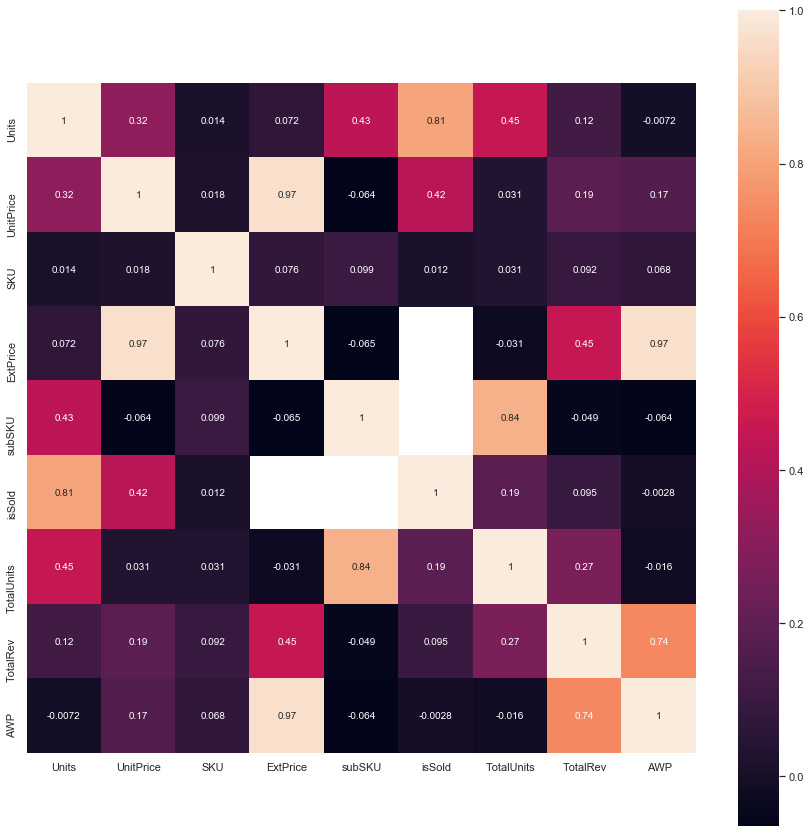

In [56]:
# Displaying a Correlation Matrix to see how things are looking with the data
plt.figure(figsize=(15, 15))
p = sns.heatmap(df_working2.corr(), annot=True, square=True)

#### Dates and Feature Engineering

Now that we have a complete set of data (that will rely on date for the prediction), it's a good idea to convert the existing 'Date' field (currently a string) into DateTime and to get some other useful information such as:
- Day of week by name (Monday - Sunday);
- Day of week by number;
- Day of month number (1-31);
- Week of year number;
- Is the day a weekend (1/0); and 
- Is the day a public holiday in Spain (0/1).

Finally get dummy variables will be sought for the Day of the Week.

In [57]:
# Identify Public Holiday
def public_holiday(row): 
    """
    Input: Date as string
    Output: 1 or 0 if the specific date is a public holiday or not.
    
    The purpose of this function is to determine if the date is a public holiday in Spain (ES)
    # This requires 'holidays' to be installed, as show in in the libraries at the start of this file.
    """
    try:
        es_holidays = holidays.CountryHoliday('ES', years=[2017])
        return(row.date_dt in es_holidays)
    except:
        return False

In [58]:
# Extracting features from string date
df_working2['date_dt']= pd.to_datetime(df_working2['Date']) #String to datetime
df_working2['date_DoW'] = df_working2['date_dt'].dt.day_name() #Day of week i.e. Monday, Tuesday
df_working2['date_DoWnum'] = df_working2['date_dt'].dt.dayofweek #Day of week number
df_working2['date_DoM'] = df_working2['date_dt'].dt.day # Day of month number
df_working2['date_WoY'] = df_working2['date_dt'].dt.week # Week number of year
df_working2['isWeekend_date'] = np.where(df_working2['date_DoW'].isin(['Sunday','Saturday']),1,0) # was isWeekend
df_working2['isPublicHol_date'] = df_working2.apply(public_holiday, axis=1).astype(int) # isPublicHol

# Get Dummies for Day of Week
dummy = pd.get_dummies(df_working2['date_DoW'])

df_working3 = df_working2.merge(dummy, left_index=True , right_index=True)

# Turn column names into is... i.e. isMonday
dict_days = {}
for i in df_working3['date_DoW'].unique():
    dict_days[i] = 'is' + i  

# Raname columns
df_working3.rename(columns=dict_days, inplace=True)
df_working3.head()

,Date,Units,UnitPrice,SKU,ExtPrice,subSKU,isSold,TotalUnits,TotalRev,AWP,...,date_WoY,isWeekend_date,isPublicHol_date,isFriday,isMonday,isSaturday,isSunday,isThursday,isTuesday,isWednesday
0,2017-03-01,1.0,102.67,3108547,102.67,0.0,1,2.0,205.34,102.670,...,9,0,0,0,0,0,0,0,0,1
1,2017-03-01,1.0,415.78,3108850,415.78,0.0,1,8.0,3326.24,415.780,...,9,0,0,0,0,0,0,0,0,1
2,2017-03-01,1.0,214.80,3109793,214.80,0.0,1,12.0,2586.42,215.535,...,9,0,0,0,0,0,0,0,0,1
3,2017-03-01,1.0,156.00,3109978,156.00,0.0,1,7.0,1092.00,156.000,...,9,0,0,0,0,0,0,0,0,1
4,2017-03-01,1.0,25.33,3114551,25.33,0.0,1,1.0,25.33,25.330,...,9,0,0,0,0,0,0,0,0,1
